In [23]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn

import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Prueba hiperparámetros 1

In [13]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6917021994183703 	 Validation loss: 0.6901809815633095 	 
  1%|          | 574/57400 [00:03<04:17, 220.61it/s]
Epoch 2 	 Training loss: 0.6882548322868679 	 Validation loss: 0.6876320121651989 	 
  2%|▏         | 1148/57400 [00:06<04:14, 220.86it/s]
Epoch 3 	 Training loss: 0.6856819616585244 	 Validation loss: 0.6858344785237717 	 
  3%|▎         | 1722/57400 [00:08<04:11, 221.43it/s]
Epoch 4 	 Training loss: 0.6838936126605974 	 Validation loss: 0.684969984878928 	 
  4%|▍         | 2296/57400 [00:11<04:08, 221.87it/s]
Epoch 5 	 Training loss: 0.6826177788736097 	 Validation loss: 0.6841621318105924 	 
  5%|▌         | 2870/57400 [00:14<04:07, 219.91it/s]
Epoch 6 	 Training loss: 0.6818264170390803 	 Validation loss: 0.6838531524448072 	 
  6%|▌         | 3444/57400 [00:17<04:11, 214.84it/s]
Epoch 7 	 Training loss: 0.6814957273546411 	 Validation loss: 0.6835925033537008 	 
  7%|▋         | 4018/57400 [00:20<04:05, 217.75it/s]
Epoch 8 	 Training loss: 0.68

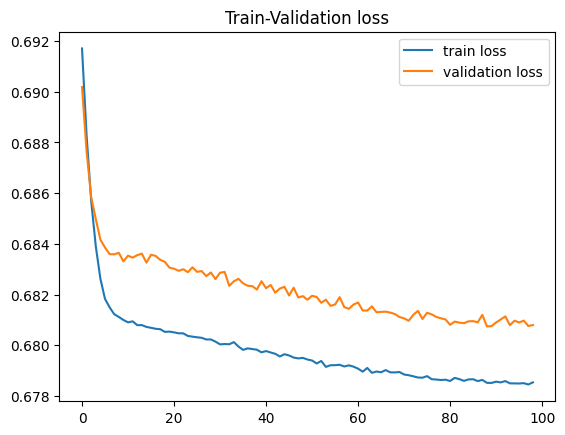

In [15]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [ ]:
# learning_rate = 5e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6883453606313114 	 Validation loss: 0.6875898838043213 	 
  1%|          | 574/57400 [00:02<04:21, 217.20it/s]
Epoch 2 	 Training loss: 0.6857062368442788 	 Validation loss: 0.6858872831878016 	 
  2%|▏         | 1148/57400 [00:05<04:22, 214.15it/s]
Epoch 3 	 Training loss: 0.6839109370517399 	 Validation loss: 0.684754299915443 	 
  3%|▎         | 1722/57400 [00:08<04:19, 214.31it/s]
Epoch 4 	 Training loss: 0.6826846109450071 	 Validation loss: 0.6840788004762035 	 
  4%|▍         | 2296/57400 [00:11<04:13, 217.74it/s]
Epoch 5 	 Training loss: 0.6819647064607733 	 Validation loss: 0.6838612849429503 	 
  5%|▌         | 2870/57400 [00:14<04:12, 216.08it/s]
Epoch 6 	 Training loss: 0.6814297544623916 	 Validation loss: 0.6837559473716607 	 
  6%|▌         | 3444/57400 [00:17<04:09, 215.93it/s]
Epoch 7 	 Training loss: 0.6811961924157491 	 Validation loss: 0.6835685180405439 	 
  7%|▋         | 4018/57400 [00:20<04:04, 218.76it/s]
Epoch 8 	 Training loss: 0.68

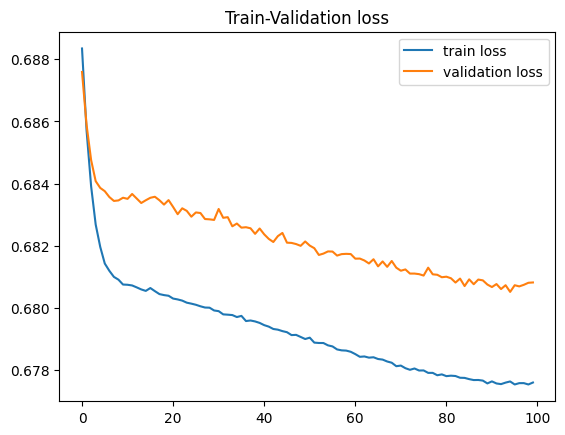

In [17]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49107142857142855, 'precision': 0.49107142857142855, 'f1': 0.49107142857142855, 'accuracy': 0.49107142857142855}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0025, 'precision': 0.0025, 'f1': 0.0025, 'accuracy': 0.0025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5151515151515151, 'precision': 0.5151515151515151, 'f1': 0.5151515151515151, 'accuracy': 0.5151515151515151}
MALE {'recall': 0.9902676399026764, 'precision': 0.9902676399026764, 'f1': 0.9902676399026764, 'accuracy': 0.9902676399026764}
FEMALE {'recall': 0.0026246719160104987, 'precision': 0.0026246719160104987, 'f1': 0.0026246719160104987, 'accuracy': 0.0026246719160104987} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6892312654011756 	 Validation loss: 0.6887881675009 	 
  1%|          | 574/57400 [00:02<04:17, 220.26it/s]
Epoch 2 	 Training loss: 0.6871208572429232 	 Validation loss: 0.6872138461824191 	 
  2%|▏         | 1148/57400 [00:05<04:29, 208.64it/s]
Epoch 3 	 Training loss: 0.6854525734946287 	 Validation loss: 0.685981567633354 	 
  3%|▎         | 1722/57400 [00:08<04:15, 217.60it/s]
Epoch 4 	 Training loss: 0.6840832765094079 	 Validation loss: 0.6851130279444032 	 
  4%|▍         | 2296/57400 [00:11<04:17, 213.65it/s]
Epoch 5 	 Training loss: 0.6831113388729427 	 Validation loss: 0.6845551517050145 	 
  5%|▌         | 2870/57400 [00:14<04:12, 215.72it/s]
Epoch 6 	 Training loss: 0.6823679298058619 	 Validation loss: 0.6842167892698514 	 
  6%|▌         | 3444/57400 [00:17<04:05, 220.07it/s]
Epoch 7 	 Training loss: 0.681857276876629 	 Validation loss: 0.6839428806709031 	 
  7%|▋         | 4018/57400 [00:20<04:05, 217.17it/s]
Epoch 8 	 Training loss: 0.681533

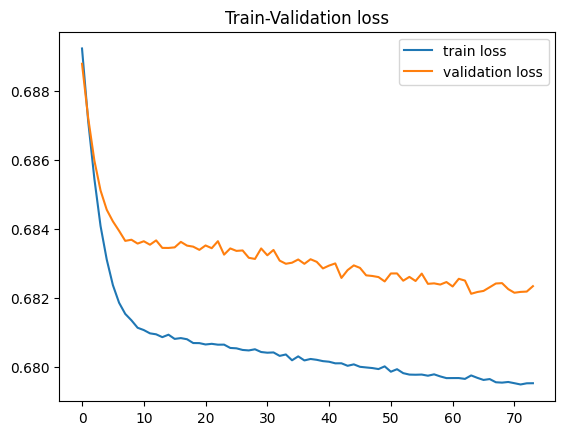

In [19]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [24]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49022108843537415, 'precision': 0.49022108843537415, 'f1': 0.49022108843537415, 'accuracy': 0.49022108843537415}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0008333333333333334, 'precision': 0.0008333333333333334, 'f1': 0.0008333333333333334, 'accuracy': 0.0008333333333333334}

 to
Resultado global: {'recall': 0.5176767676767676, 'precision': 0.5176767676767676, 'f1': 0.5176767676767676, 'accuracy': 0.5176767676767676}
Métricas etiqueta male: {'recall': 0.9967558799675588, 'precision': 0.9967558799675588, 'f1': 0.9967558799675588, 'accuracy': 0.9967558799675588}
Métricas etiqueta female:  {'recall': 0.0008748906386701663, 'precision': 0.0008748906386701663, 'f1': 0.0008748906386701663, 'accuracy': 0.0008748906386701663}

 as
Resultado global: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.5162

## TO

In [25]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937964161929353 	 Validation loss: 0.6951950919830193 	 
  1%|          | 574/57400 [00:03<05:16, 179.81it/s]
Epoch 2 	 Training loss: 0.693507933969697 	 Validation loss: 0.6943621342465028 	 
  2%|▏         | 1148/57400 [00:07<05:16, 177.88it/s]
Epoch 3 	 Training loss: 0.6933733186447661 	 Validation loss: 0.6941884796498186 	 
  3%|▎         | 1722/57400 [00:10<05:21, 173.07it/s]
Epoch 4 	 Training loss: 0.693341461727428 	 Validation loss: 0.6937992158582655 	 
  4%|▍         | 2296/57400 [00:13<05:10, 177.41it/s]
Epoch 5 	 Training loss: 0.693223814515702 	 Validation loss: 0.6935782291121402 	 
  5%|▌         | 2870/57400 [00:17<05:07, 177.53it/s]
Epoch 6 	 Training loss: 0.6931924041139955 	 Validation loss: 0.69345379683931 	 
  6%|▌         | 3444/57400 [00:20<05:05, 176.64it/s]
Epoch 7 	 Training loss: 0.6931934930929323 	 Validation loss: 0.6932215993687257 	 
  7%|▋         | 4018/57400 [00:24<04:58, 178.82it/s]
Epoch 8 	 Training loss: 0.693182

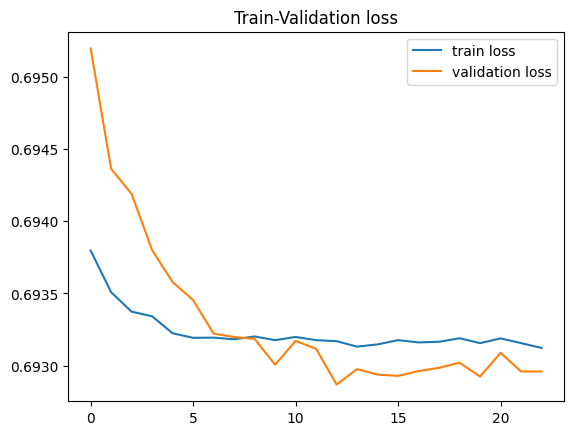

In [26]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5306122448979592, 'precision': 0.5306122448979592, 'f1': 0.5306122448979592, 'accuracy': 0.5306122448979592}
MALE {'recall': 0.59375, 'precision': 0.59375, 'f1': 0.59375, 'accuracy': 0.59375}
FEMALE {'recall': 0.47, 'precision': 0.47, 'f1': 0.47, 'accuracy': 0.47} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5214646464646465, 'precision': 0.5214646464646465, 'f1': 0.5214646464646465, 'accuracy': 0.5214646464646465}
MALE {'recall': 0.5936739659367397, 'precision': 0.5936739659367397, 'f1': 0.5936739659367397, 'accuracy': 0.5936739659367397}
FEMALE {'recall': 0.4435695538057743, 'precision': 0.4435695538057743, 'f1': 0.4435695538057743, 'accuracy': 0.4435695538057743} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5202086049543677, 'precision': 0.5202086049543677, 'f1': 0.5202086049543677, 'accuracy': 0.5202086049543677}
MALE {'recall': 0.5732323232323232, 'precision': 0.5732323232323232,

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693277333048578 	 Validation loss: 0.6936502992096594 	 
  1%|          | 574/57400 [00:03<05:21, 176.59it/s]
Epoch 2 	 Training loss: 0.6932511029550839 	 Validation loss: 0.6933743115198814 	 
  2%|▏         | 1148/57400 [00:06<05:12, 179.99it/s]
Epoch 3 	 Training loss: 0.6932114386600069 	 Validation loss: 0.6930686255632821 	 
  3%|▎         | 1722/57400 [00:10<05:03, 183.37it/s]
Epoch 4 	 Training loss: 0.693262616931769 	 Validation loss: 0.6930054678755292 	 
  4%|▍         | 2296/57400 [00:13<05:10, 177.47it/s]
Epoch 5 	 Training loss: 0.6931778423046816 	 Validation loss: 0.6926600094568931 	 
  5%|▌         | 2870/57400 [00:17<05:08, 176.82it/s]
Epoch 6 	 Training loss: 0.6931781628613688 	 Validation loss: 0.693014877327418 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:20<05:08, 175.15it/s]
Epoch 7 	 Training loss: 0.6931681589382451 	 Validation loss: 0.6931013737694692 	 

2 epoch without improvement
  7%|▋         | 4018/57400

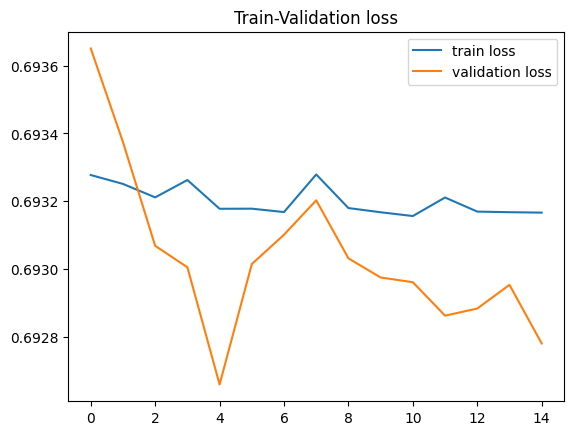

In [28]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5459183673469388, 'precision': 0.5459183673469388, 'f1': 0.5459183673469388, 'accuracy': 0.5459183673469388}
MALE {'recall': 0.2916666666666667, 'precision': 0.2916666666666667, 'f1': 0.2916666666666667, 'accuracy': 0.2916666666666667}
FEMALE {'recall': 0.79, 'precision': 0.79, 'f1': 0.79, 'accuracy': 0.79} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.30656934306569344, 'precision': 0.30656934306569344, 'f1': 0.30656934306569344, 'accuracy': 0.30656934306569344}
FEMALE {'recall': 0.6692913385826772, 'precision': 0.6692913385826772, 'f1': 0.6692913385826772, 'accuracy': 0.6692913385826772} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4654498044328553, 'precision': 0.4654498044328553, 'f1': 0.4654498044328553, 'accuracy': 0.4654498044328553}
MALE {'recall': 0.30

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945118095193591 	 Validation loss: 0.6955616484254094 	 
  1%|          | 574/57400 [00:03<05:14, 180.47it/s]
Epoch 2 	 Training loss: 0.6938771155860781 	 Validation loss: 0.6949111182810896 	 
  2%|▏         | 1148/57400 [00:06<05:17, 177.44it/s]
Epoch 3 	 Training loss: 0.6936686086737736 	 Validation loss: 0.6947555309635097 	 
  3%|▎         | 1722/57400 [00:10<05:31, 167.96it/s]
Epoch 4 	 Training loss: 0.6935084545238508 	 Validation loss: 0.6942448545310457 	 
  4%|▍         | 2296/57400 [00:13<04:57, 184.96it/s]
Epoch 5 	 Training loss: 0.6933940428890002 	 Validation loss: 0.6936486171463788 	 
  5%|▌         | 2870/57400 [00:17<04:48, 189.32it/s]
Epoch 6 	 Training loss: 0.6933763359481865 	 Validation loss: 0.6935266953403667 	 
  6%|▌         | 3444/57400 [00:20<04:54, 182.97it/s]
Epoch 7 	 Training loss: 0.6933448904482745 	 Validation loss: 0.6934347213324854 	 
  7%|▋         | 4018/57400 [00:23<04:46, 186.30it/s]
Epoch 8 	 Training loss: 0.6

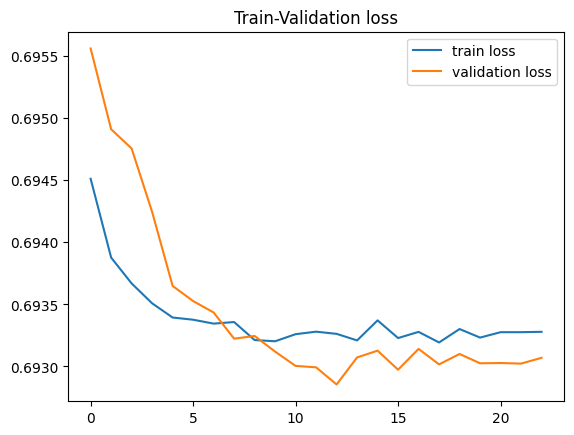

In [30]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [31]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.7760416666666666, 'precision': 0.7760416666666666, 'f1': 0.7760416666666666, 'accuracy': 0.7760416666666666}
FEMALE {'recall': 0.2525, 'precision': 0.2525, 'f1': 0.2525, 'accuracy': 0.2525} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.51010101010101, 'precision': 0.51010101010101, 'f1': 0.51010101010101, 'accuracy': 0.51010101010101}
MALE {'recall': 0.7883211678832117, 'precision': 0.7883211678832117, 'f1': 0.7883211678832118, 'accuracy': 0.7883211678832117}
FEMALE {'recall': 0.2099737532808399, 'precision': 0.2099737532808399, 'f1': 0.2099737532808399, 'accuracy': 0.2099737532808399} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.500651890482399, 'precision': 0.500651890482399, 'f1': 0.500651890482399, 'accuracy': 0.500651890482399}
MALE {'recall': 0.7803030303

In [32]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5284863945578231, 'precision': 0.5284863945578231, 'f1': 0.5284863945578231, 'accuracy': 0.5284863945578231}
Métricas etiqueta male: {'recall': 0.5538194444444444, 'precision': 0.5538194444444444, 'f1': 0.5538194444444444, 'accuracy': 0.5538194444444444}
Métricas etiqueta female:  {'recall': 0.5041666666666667, 'precision': 0.5041666666666667, 'f1': 0.5041666666666667, 'accuracy': 0.5041666666666667}

 to
Resultado global: {'recall': 0.5042087542087542, 'precision': 0.5042087542087542, 'f1': 0.5042087542087542, 'accuracy': 0.5042087542087542}
Métricas etiqueta male: {'recall': 0.5628548256285483, 'precision': 0.5628548256285483, 'f1': 0.5628548256285484, 'accuracy': 0.5628548256285483}
Métricas etiqueta female:  {'recall': 0.4409448818897638, 'precision': 0.4409448818897638, 'f1': 0.4409448818897638, 'accuracy': 0.4409448818897638}

 as
Resultado global: {'recall': 0.49543676662320735, 'precision': 0.49543676662320735, 'f1': 0

# AS

In [33]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932393747547362 	 Validation loss: 0.6933086595292819 	 
  1%|          | 574/57400 [00:03<05:15, 180.19it/s]
Epoch 2 	 Training loss: 0.6931782941161964 	 Validation loss: 0.6931702989642903 	 
  2%|▏         | 1148/57400 [00:06<05:19, 176.28it/s]
Epoch 3 	 Training loss: 0.6931536391844733 	 Validation loss: 0.693203843246072 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:09, 180.10it/s]
Epoch 4 	 Training loss: 0.6931041586066787 	 Validation loss: 0.6931135351374998 	 
  4%|▍         | 2296/57400 [00:13<05:06, 179.94it/s]
Epoch 5 	 Training loss: 0.693192832665161 	 Validation loss: 0.6931026284977541 	 
  5%|▌         | 2870/57400 [00:17<05:07, 177.34it/s]
Epoch 6 	 Training loss: 0.6931968479829382 	 Validation loss: 0.6931888622752691 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:21<09:02, 99.55it/s]
Epoch 7 	 Training loss: 0.6931640007354657 	 Validation loss: 0.6930195487151711 	 
  7%|▋         | 4018/57400

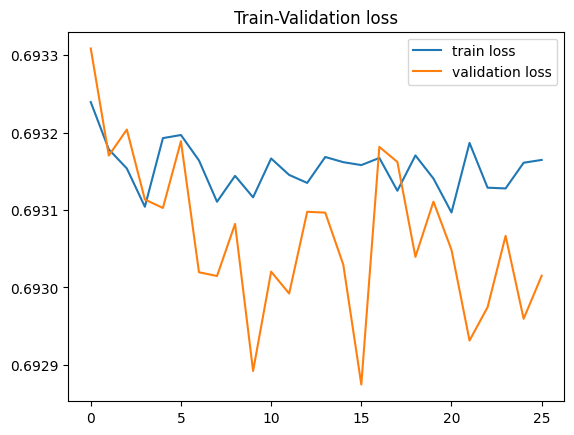

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5178571428571429, 'precision': 0.5178571428571429, 'f1': 0.5178571428571429, 'accuracy': 0.5178571428571429}
MALE {'recall': 0.2864583333333333, 'precision': 0.2864583333333333, 'f1': 0.2864583333333333, 'accuracy': 0.2864583333333333}
FEMALE {'recall': 0.74, 'precision': 0.74, 'f1': 0.74, 'accuracy': 0.74} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.2773722627737226, 'precision': 0.2773722627737226, 'f1': 0.2773722627737226, 'accuracy': 0.2773722627737226}
FEMALE {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE {'recall': 0.280303

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952513346273309 	 Validation loss: 0.691338715916973 	 
  1%|          | 574/57400 [00:03<05:21, 176.71it/s]
Epoch 2 	 Training loss: 0.6944557444974521 	 Validation loss: 0.6927471635705333 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<05:05, 184.14it/s]
Epoch 3 	 Training loss: 0.6940661053001258 	 Validation loss: 0.6914131206981207 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:03, 183.18it/s]
Epoch 4 	 Training loss: 0.6938494718033262 	 Validation loss: 0.6923099382449005 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:13<05:03, 181.48it/s]
Epoch 5 	 Training loss: 0.6935768868865037 	 Validation loss: 0.6919306597467196 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:16<04:50, 187.61it/s]
Epoch 6 	 Training loss: 0.6934160526828899 	 Validation loss: 0.6925476092403218 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:20<04:49, 186.22it/s]
Epoch 7 	 Training loss

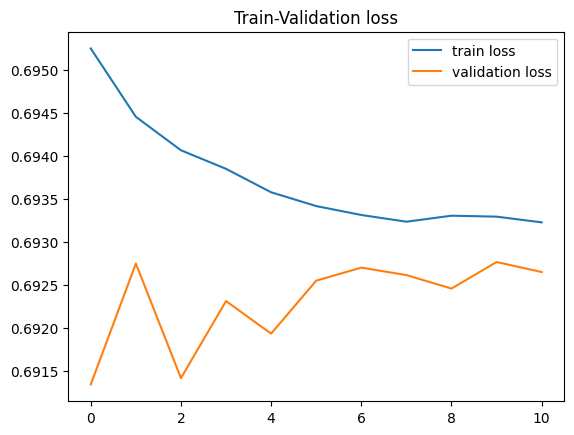

In [36]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944375324747704 	 Validation loss: 0.6958650865797269 	 
  1%|          | 574/57400 [00:03<05:20, 177.30it/s]
Epoch 2 	 Training loss: 0.6943608052016136 	 Validation loss: 0.69527024838884 	 
  2%|▏         | 1148/57400 [00:06<05:17, 177.26it/s]
Epoch 3 	 Training loss: 0.6938527503703114 	 Validation loss: 0.6950843010918569 	 
  3%|▎         | 1722/57400 [00:10<05:17, 175.42it/s]
Epoch 4 	 Training loss: 0.6935851724513317 	 Validation loss: 0.6943556151147616 	 
  4%|▍         | 2296/57400 [00:13<05:06, 179.82it/s]
Epoch 5 	 Training loss: 0.6933788965595724 	 Validation loss: 0.6939989106129791 	 
  5%|▌         | 2870/57400 [00:17<05:03, 179.42it/s]
Epoch 6 	 Training loss: 0.6932718981226147 	 Validation loss: 0.6938248185788171 	 
  6%|▌         | 3444/57400 [00:20<05:02, 178.40it/s]
Epoch 7 	 Training loss: 0.6932416631992686 	 Validation loss: 0.6936913092257613 	 
  7%|▋         | 4018/57400 [00:24<05:01, 176.86it/s]
Epoch 8 	 Training loss: 0.693

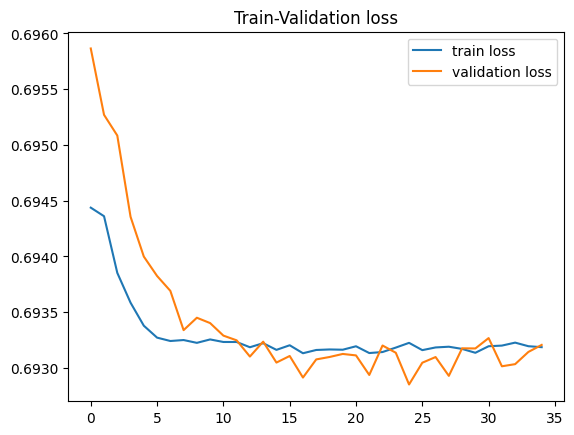

In [38]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v1_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [39]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
MALE {'recall': 0.11197916666666667, 'precision': 0.11197916666666667, 'f1': 0.11197916666666667, 'accuracy': 0.11197916666666667}
FEMALE {'recall': 0.895, 'precision': 0.895, 'f1': 0.895, 'accuracy': 0.895} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4696969696969697, 'precision': 0.4696969696969697, 'f1': 0.4696969696969697, 'accuracy': 0.4696969696969697}
MALE {'recall': 0.09245742092457421, 'precision': 0.09245742092457421, 'f1': 0.09245742092457421, 'accuracy': 0.09245742092457421}
FEMALE {'recall': 0.8766404199475065, 'precision': 0.8766404199475065, 'f1': 0.8766404199475065, 'accuracy': 0.8766404199475065} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE {'r

In [40]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5131802721088435, 'precision': 0.5131802721088435, 'f1': 0.5131802721088435, 'accuracy': 0.5131802721088435}
Métricas etiqueta male: {'recall': 0.1328125, 'precision': 0.1328125, 'f1': 0.1328125, 'accuracy': 0.1328125}
Métricas etiqueta female:  {'recall': 0.8783333333333333, 'precision': 0.8783333333333333, 'f1': 0.8783333333333333, 'accuracy': 0.8783333333333333}

 to
Resultado global: {'recall': 0.4776936026936027, 'precision': 0.4776936026936027, 'f1': 0.4776936026936027, 'accuracy': 0.4776936026936027}
Métricas etiqueta male: {'recall': 0.1232765612327656, 'precision': 0.1232765612327656, 'f1': 0.1232765612327656, 'accuracy': 0.1232765612327656}
Métricas etiqueta female:  {'recall': 0.8600174978127734, 'precision': 0.8600174978127734, 'f1': 0.8600174978127734, 'accuracy': 0.8600174978127734}

 as
Resultado global: {'recall': 0.4867448935245545, 'precision': 0.4867448935245545, 'f1': 0.4867448935245545, 'accuracy': 0.48674

# Pruebas hiperparámetros 2

In [41]:
emb_dim = 20
vocab_size = len(word_to_index)
# num_labels = 2
lstm_hidden_dim = 64

## ABOUT

In [42]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6997430956945186 	 Validation loss: 0.6976143889508005 	 
  1%|          | 574/57400 [00:02<03:20, 284.01it/s]
Epoch 2 	 Training loss: 0.6964905266147042 	 Validation loss: 0.6949233119770631 	 
  2%|▏         | 1148/57400 [00:04<03:23, 275.79it/s]
Epoch 3 	 Training loss: 0.6935855560394114 	 Validation loss: 0.6925785208152513 	 
  3%|▎         | 1722/57400 [00:06<03:17, 282.30it/s]
Epoch 4 	 Training loss: 0.6911046434362591 	 Validation loss: 0.6905481896157992 	 
  4%|▍         | 2296/57400 [00:08<03:16, 280.01it/s]
Epoch 5 	 Training loss: 0.6888770534809459 	 Validation loss: 0.6888144228417995 	 
  5%|▌         | 2870/57400 [00:10<03:17, 276.61it/s]
Epoch 6 	 Training loss: 0.6869292180297266 	 Validation loss: 0.687334899174965 	 
  6%|▌         | 3444/57400 [00:13<03:11, 282.09it/s]
Epoch 7 	 Training loss: 0.6855284116824745 	 Validation loss: 0.686365801399037 	 
  7%|▋         | 4018/57400 [00:15<03:12, 276.66it/s]
Epoch 8 	 Training loss: 0.684

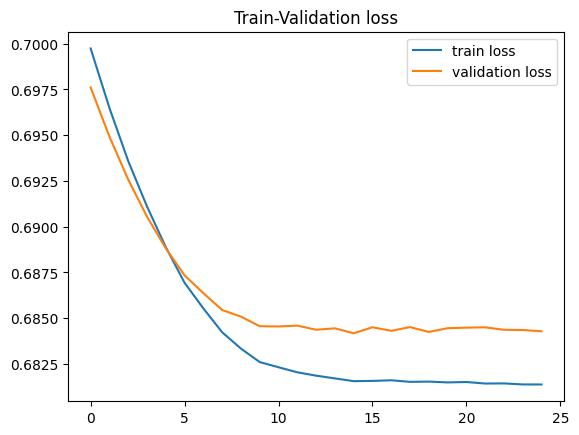

In [43]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [44]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49107142857142855, 'precision': 0.49107142857142855, 'f1': 0.49107142857142855, 'accuracy': 0.49107142857142855}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0025, 'precision': 0.0025, 'f1': 0.0025, 'accuracy': 0.0025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0026246719160104987, 'precision': 0.0026246719160104987, 'f1': 0.0026246719160104987, 'accuracy': 0.0026246719160104987} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5189048239895697, 'precision': 0.5189048239895697, 'f1': 0.5189048239895697, 'accuracy': 0.5189048239895697}
MALE {'recall': 0.9974747474747475, 'precision': 0.9974747474747475, 'f1': 0.9974747474747475, 'accuracy': 0.99747474747

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6920041531220545 	 Validation loss: 0.6910800499431158 	 
  1%|          | 574/57400 [00:02<03:22, 280.17it/s]
Epoch 2 	 Training loss: 0.6896818509708298 	 Validation loss: 0.6893035001673941 	 
  2%|▏         | 1148/57400 [00:04<03:20, 281.12it/s]
Epoch 3 	 Training loss: 0.6878098775908507 	 Validation loss: 0.6878909832340175 	 
  3%|▎         | 1722/57400 [00:06<03:16, 282.65it/s]
Epoch 4 	 Training loss: 0.6862336273600416 	 Validation loss: 0.6867832996077456 	 
  4%|▍         | 2296/57400 [00:08<03:20, 275.05it/s]
Epoch 5 	 Training loss: 0.6849801652522868 	 Validation loss: 0.6859210487139427 	 
  5%|▌         | 2870/57400 [00:10<03:12, 283.28it/s]
Epoch 6 	 Training loss: 0.6838722399302891 	 Validation loss: 0.685170684830617 	 
  6%|▌         | 3444/57400 [00:13<03:13, 279.24it/s]
Epoch 7 	 Training loss: 0.683060495072541 	 Validation loss: 0.6849057048054065 	 
  7%|▋         | 4018/57400 [00:15<03:12, 277.17it/s]
Epoch 8 	 Training loss: 0.682

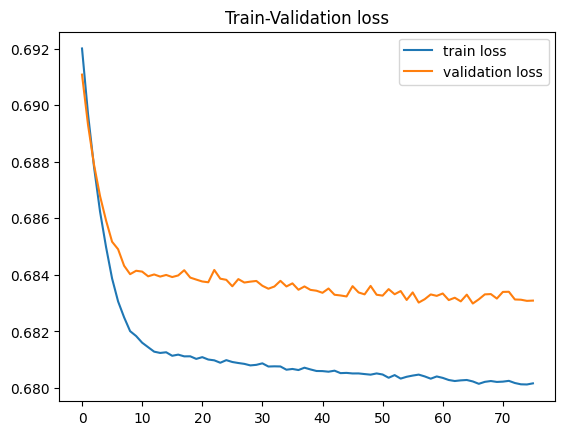

In [45]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [46]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955902997001954 	 Validation loss: 0.6940522244421102 	 
  1%|          | 574/57400 [00:02<03:25, 276.88it/s]
Epoch 2 	 Training loss: 0.6929636123080702 	 Validation loss: 0.6919291948868056 	 
  2%|▏         | 1148/57400 [00:04<03:25, 274.21it/s]
Epoch 3 	 Training loss: 0.6906350811599439 	 Validation loss: 0.690082591469005 	 
  3%|▎         | 1722/57400 [00:06<03:25, 270.77it/s]
Epoch 4 	 Training loss: 0.6886720280406367 	 Validation loss: 0.6885490073996076 	 
  4%|▍         | 2296/57400 [00:08<03:18, 277.82it/s]
Epoch 5 	 Training loss: 0.6869285360030596 	 Validation loss: 0.6871590594113883 	 
  5%|▌         | 2870/57400 [00:11<03:13, 282.15it/s]
Epoch 6 	 Training loss: 0.6854626385800099 	 Validation loss: 0.6861027438761824 	 
  6%|▌         | 3444/57400 [00:13<03:11, 281.49it/s]
Epoch 7 	 Training loss: 0.6843148462656068 	 Validation loss: 0.6854180360244493 	 
  7%|▋         | 4018/57400 [00:15<03:10, 279.96it/s]
Epoch 8 	 Training loss: 0.68

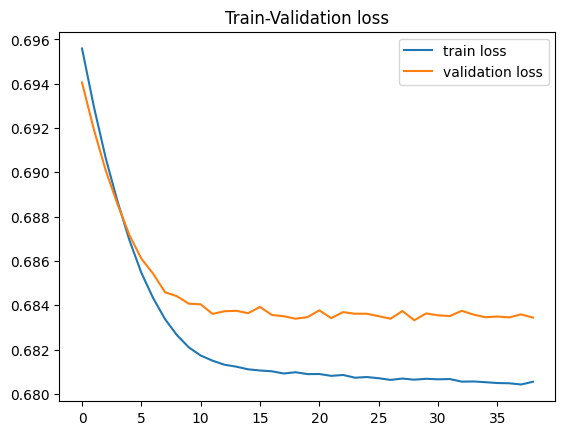

In [47]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_about_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [48]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [49]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49022108843537415, 'precision': 0.49022108843537415, 'f1': 0.49022108843537415, 'accuracy': 0.49022108843537415}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0008333333333333334, 'precision': 0.0008333333333333334, 'f1': 0.0008333333333333334, 'accuracy': 0.0008333333333333334}

 to
Resultado global: {'recall': 0.5193602693602694, 'precision': 0.5193602693602694, 'f1': 0.5193602693602694, 'accuracy': 0.5193602693602694}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0008748906386701663, 'precision': 0.0008748906386701663, 'f1': 0.0008748906386701663, 'accuracy': 0.0008748906386701663}

 as
Resultado global: {'recall': 0.5171664493698392, 'precision': 0.5171664493698392, 'f1': 0.5171664493698392, 'accuracy': 0.5171664493698392}
Métricas etiqueta male: {'recall': 0.999158

## TO

In [54]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939612762022517 	 Validation loss: 0.6954490633334144 	 
  1%|          | 574/57400 [00:02<04:23, 215.55it/s]
Epoch 2 	 Training loss: 0.6936893692623032 	 Validation loss: 0.6947193812515776 	 
  2%|▏         | 1148/57400 [00:05<04:20, 215.62it/s]
Epoch 3 	 Training loss: 0.6936002185743445 	 Validation loss: 0.6948493607973648 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:21, 213.25it/s]
Epoch 4 	 Training loss: 0.693439233178461 	 Validation loss: 0.6942988916978998 	 
  4%|▍         | 2296/57400 [00:11<04:26, 206.52it/s]
Epoch 5 	 Training loss: 0.693491494510232 	 Validation loss: 0.6940105729183909 	 
  5%|▌         | 2870/57400 [00:14<04:17, 211.86it/s]
Epoch 6 	 Training loss: 0.6933720540709611 	 Validation loss: 0.6938070159847454 	 
  6%|▌         | 3444/57400 [00:17<04:16, 210.17it/s]
Epoch 7 	 Training loss: 0.6932828553046915 	 Validation loss: 0.6936308852696823 	 
  7%|▋         | 4018/57400 [00:20<04:09, 213.99it/s]
E

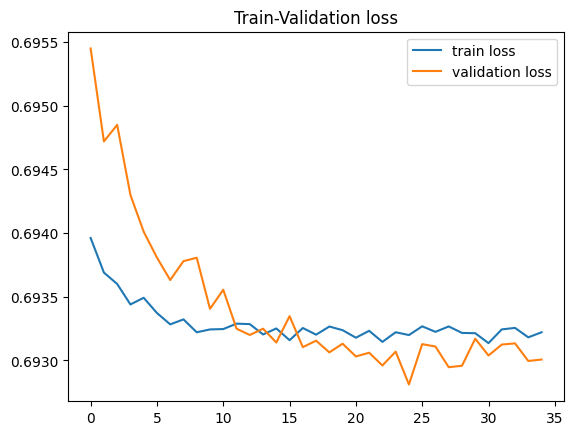

In [51]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [55]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load('m1_rrnn_simple_to_v2_1'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.41964285714285715, 'precision': 0.41964285714285715, 'f1': 0.41964285714285715, 'accuracy': 0.41964285714285715}
MALE {'recall': 0.6067708333333334, 'precision': 0.6067708333333334, 'f1': 0.6067708333333334, 'accuracy': 0.6067708333333334}
FEMALE {'recall': 0.24, 'precision': 0.24, 'f1': 0.24, 'accuracy': 0.24} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5088383838383839, 'precision': 0.5088383838383839, 'f1': 0.5088383838383839, 'accuracy': 0.5088383838383839}
MALE {'recall': 0.6958637469586375, 'precision': 0.6958637469586375, 'f1': 0.6958637469586375, 'accuracy': 0.6958637469586375}
FEMALE {'recall': 0.30708661417322836, 'precision': 0.30708661417322836, 'f1': 0.30708661417322836, 'accuracy': 0.30708661417322836} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5110821382007823, 'precision': 0.5110821382007823, 'f1': 0.5110821382007823, 'accuracy': 0.5110821382007823}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695315065907269 	 Validation loss: 0.6981176966327732 	 
  1%|          | 574/57400 [00:03<04:31, 209.23it/s]
Epoch 2 	 Training loss: 0.6950519507562657 	 Validation loss: 0.6976114602412208 	 
  2%|▏         | 1148/57400 [00:06<04:33, 205.99it/s]
Epoch 3 	 Training loss: 0.6945978486164106 	 Validation loss: 0.6966801093796552 	 
  3%|▎         | 1722/57400 [00:09<04:27, 208.51it/s]
Epoch 4 	 Training loss: 0.6943514820590667 	 Validation loss: 0.6965594635171405 	 
  4%|▍         | 2296/57400 [00:12<04:25, 207.43it/s]
Epoch 5 	 Training loss: 0.6940019031019576 	 Validation loss: 0.6953500509262085 	 
  5%|▌         | 2870/57400 [00:15<04:24, 206.00it/s]
Epoch 6 	 Training loss: 0.6936812167175971 	 Validation loss: 0.6952102436857709 	 
  6%|▌         | 3444/57400 [00:18<04:18, 209.00it/s]
Epoch 7 	 Training loss: 0.6936309630447148 	 Validation loss: 0.6951457645933506 	 
  7%|▋         | 4018/57400 [00:21<04:14, 209.73it/s]
Epoch 8 	 Training loss: 0.69

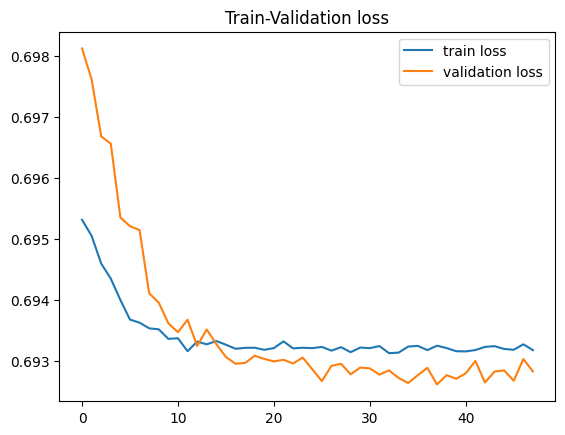

In [56]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [57]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.461734693877551, 'precision': 0.461734693877551, 'f1': 0.461734693877551, 'accuracy': 0.461734693877551}
MALE {'recall': 0.25, 'precision': 0.25, 'f1': 0.25, 'accuracy': 0.25}
FEMALE {'recall': 0.665, 'precision': 0.665, 'f1': 0.665, 'accuracy': 0.665} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.49873737373737376, 'precision': 0.49873737373737376, 'f1': 0.49873737373737376, 'accuracy': 0.49873737373737376}
MALE {'recall': 0.3260340632603406, 'precision': 0.3260340632603406, 'f1': 0.3260340632603406, 'accuracy': 0.3260340632603406}
FEMALE {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4863102998696219, 'precision': 0.4863102998696219, 'f1': 0.4863102998696219, 'accuracy': 0.4863102998696219}
MALE {'recall': 0.29292929292929293, 'precision': 0.29292929292929293, 'f1':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944956026633857 	 Validation loss: 0.6912223464351589 	 
  1%|          | 574/57400 [00:03<04:40, 202.91it/s]
Epoch 2 	 Training loss: 0.6940427393448062 	 Validation loss: 0.691324116819996 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:06<04:32, 206.72it/s]
Epoch 3 	 Training loss: 0.6939542422311231 	 Validation loss: 0.690684423608295 	 
  3%|▎         | 1722/57400 [00:09<04:26, 208.76it/s]
Epoch 4 	 Training loss: 0.6939004243250924 	 Validation loss: 0.6915955614235442 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:12<04:27, 205.62it/s]
Epoch 5 	 Training loss: 0.693627197256487 	 Validation loss: 0.6922629192724066 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:15<04:28, 203.44it/s]
Epoch 6 	 Training loss: 0.6935328605490695 	 Validation loss: 0.6918720451451964 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:18<04:17, 209.56it/s]
Epoch 7 	 Training loss: 0.6934279894994941 	 Validati

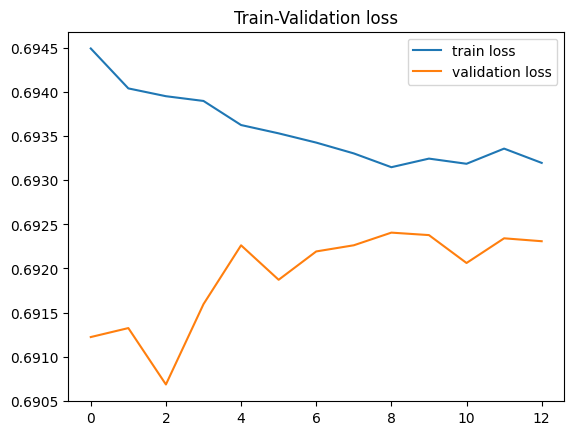

In [58]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_to_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [60]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [61]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4638605442176871, 'precision': 0.4638605442176871, 'f1': 0.4638605442176871, 'accuracy': 0.4638605442176871}
Métricas etiqueta male: {'recall': 0.2855902777777778, 'precision': 0.2855902777777778, 'f1': 0.2855902777777778, 'accuracy': 0.2855902777777778}
Métricas etiqueta female:  {'recall': 0.635, 'precision': 0.635, 'f1': 0.635, 'accuracy': 0.635}

 to
Resultado global: {'recall': 0.4962121212121212, 'precision': 0.4962121212121212, 'f1': 0.4962121212121212, 'accuracy': 0.4962121212121212}
Métricas etiqueta male: {'recall': 0.34063260340632606, 'precision': 0.34063260340632606, 'f1': 0.34063260340632606, 'accuracy': 0.34063260340632606}
Métricas etiqueta female:  {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562}

 as
Resultado global: {'recall': 0.49369839200347676, 'precision': 0.49369839200347676, 'f1': 0.49369839200347676, 'accuracy': 0.49369839200347

## AS

In [62]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6934633854166556 	 Validation loss: 0.6943572406041421 	 
  1%|          | 574/57400 [00:03<04:29, 210.51it/s]
Epoch 2 	 Training loss: 0.693350319870673 	 Validation loss: 0.6940676186044338 	 
  2%|▏         | 1148/57400 [00:05<04:24, 213.08it/s]
Epoch 3 	 Training loss: 0.6933362248259555 	 Validation loss: 0.6937737515417196 	 
  3%|▎         | 1722/57400 [00:08<04:23, 211.21it/s]
Epoch 4 	 Training loss: 0.6933717686124795 	 Validation loss: 0.6935535689531747 	 
  4%|▍         | 2296/57400 [00:11<04:28, 205.54it/s]
Epoch 5 	 Training loss: 0.6933112421725269 	 Validation loss: 0.6933309213589813 	 
  5%|▌         | 2870/57400 [00:14<04:17, 212.00it/s]
Epoch 6 	 Training loss: 0.6933137610398934 	 Validation loss: 0.6931699069879823 	 
  6%|▌         | 3444/57400 [00:17<04:08, 217.40it/s]
Epoch 7 	 Training loss: 0.6932494031842993 	 Validation loss: 0.6933027041160454 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:20<04:17, 207.50it/s]


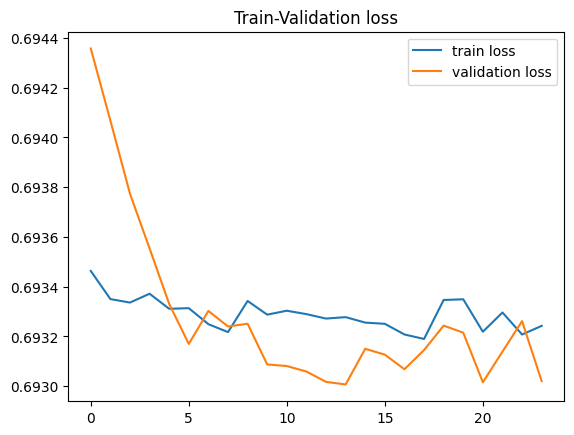

In [63]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [64]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.461734693877551, 'precision': 0.461734693877551, 'f1': 0.461734693877551, 'accuracy': 0.461734693877551}
MALE {'recall': 0.7786458333333334, 'precision': 0.7786458333333334, 'f1': 0.7786458333333334, 'accuracy': 0.7786458333333334}
FEMALE {'recall': 0.1575, 'precision': 0.1575, 'f1': 0.1575, 'accuracy': 0.1575} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5126262626262627, 'precision': 0.5126262626262627, 'f1': 0.5126262626262627, 'accuracy': 0.5126262626262627}
MALE {'recall': 0.7737226277372263, 'precision': 0.7737226277372263, 'f1': 0.7737226277372263, 'accuracy': 0.7737226277372263}
FEMALE {'recall': 0.23097112860892388, 'precision': 0.23097112860892388, 'f1': 0.23097112860892388, 'accuracy': 0.23097112860892388} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5241199478487614, 'precision': 0.5241199478487614, 'f1': 0.5241199478487614, 'accuracy': 0.5241199478487614}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947270924621343 	 Validation loss: 0.6958440330068943 	 
  1%|          | 574/57400 [00:02<04:21, 217.65it/s]
Epoch 2 	 Training loss: 0.6939821892291411 	 Validation loss: 0.6952426494178126 	 
  2%|▏         | 1148/57400 [00:05<04:19, 216.45it/s]
Epoch 3 	 Training loss: 0.6938647750362702 	 Validation loss: 0.6950087537199764 	 
  3%|▎         | 1722/57400 [00:08<04:14, 219.11it/s]
Epoch 4 	 Training loss: 0.69364919147425 	 Validation loss: 0.6941992832442462 	 
  4%|▍         | 2296/57400 [00:11<04:17, 214.11it/s]
Epoch 5 	 Training loss: 0.6934984967060621 	 Validation loss: 0.6944976075220917 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:11, 216.81it/s]
Epoch 6 	 Training loss: 0.6932930702324113 	 Validation loss: 0.6940924959667658 	 
  6%|▌         | 3444/57400 [00:17<04:08, 217.36it/s]
Epoch 7 	 Training loss: 0.6933021001284131 	 Validation loss: 0.6938682440984048 	 
  7%|▋         | 4018/57400 [00:20<04:07, 216.08it/s]
E

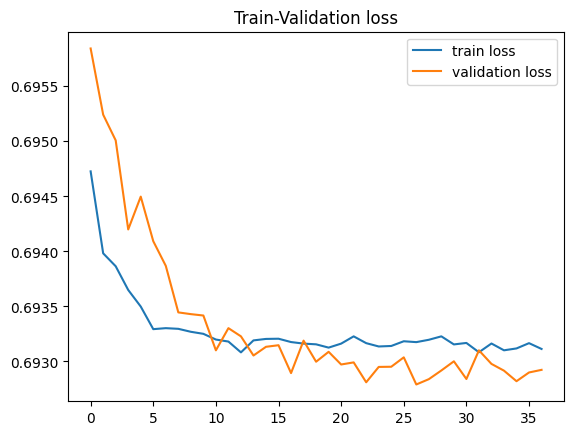

In [65]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [66]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.49489795918367346, 'precision': 0.49489795918367346, 'f1': 0.49489795918367346, 'accuracy': 0.49489795918367346}
MALE {'recall': 0.08072916666666667, 'precision': 0.08072916666666667, 'f1': 0.08072916666666667, 'accuracy': 0.08072916666666667}
FEMALE {'recall': 0.8925, 'precision': 0.8925, 'f1': 0.8925, 'accuracy': 0.8925} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.10462287104622871, 'precision': 0.10462287104622871, 'f1': 0.10462287104622871, 'accuracy': 0.10462287104622871}
FEMALE {'recall': 0.8766404199475065, 'precision': 0.8766404199475065, 'f1': 0.8766404199475065, 'accuracy': 0.8766404199475065} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4706649282920469, 'precision': 0.4706649282920469, 'f1': 0.4706649282920469, 'accuracy': 0.4706649282920469}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6941991771347431 	 Validation loss: 0.6907821307748051 	 
  1%|          | 574/57400 [00:02<04:25, 213.93it/s]
Epoch 2 	 Training loss: 0.6941195760662132 	 Validation loss: 0.6920751474671445 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:05<04:15, 220.05it/s]
Epoch 3 	 Training loss: 0.6939108542033604 	 Validation loss: 0.6919345047514317 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:08<04:14, 218.45it/s]
Epoch 4 	 Training loss: 0.6935597353903674 	 Validation loss: 0.6922702223567639 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:11<04:14, 216.35it/s]
Epoch 5 	 Training loss: 0.6933998392849434 	 Validation loss: 0.6925975902605865 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:14<04:18, 211.33it/s]
Epoch 6 	 Training loss: 0.6934515949118013 	 Validation loss: 0.6926522962117599 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:17<04:11, 214.36it/s]
Epoch 7 	 Training los

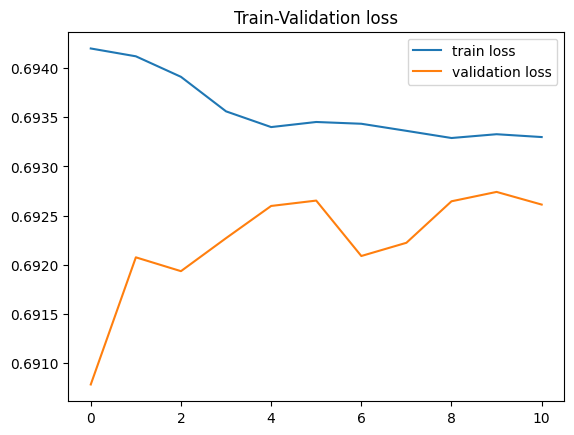

In [67]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path='m1_rrnn_simple_as_v2_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [68]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [69]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.48894557823129253, 'precision': 0.48894557823129253, 'f1': 0.48894557823129253, 'accuracy': 0.48894557823129253}
Métricas etiqueta male: {'recall': 0.28645833333333337, 'precision': 0.28645833333333337, 'f1': 0.28645833333333337, 'accuracy': 0.28645833333333337}
Métricas etiqueta female:  {'recall': 0.6833333333333333, 'precision': 0.6833333333333333, 'f1': 0.6833333333333333, 'accuracy': 0.6833333333333333}

 to
Resultado global: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
Métricas etiqueta male: {'recall': 0.29278183292781834, 'precision': 0.29278183292781834, 'f1': 0.29278183292781834, 'accuracy': 0.29278183292781834}
Métricas etiqueta female:  {'recall': 0.7025371828521435, 'precision': 0.7025371828521435, 'f1': 0.7025371828521435, 'accuracy': 0.7025371828521435}

 as
Resultado global: {'recall': 0.49282920469361147, 'precision': 0.49282920469361